# Fish Image Classification with ANN

**1. Set up the environment**

In [1]:
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  2


In [2]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential, layers
from keras.optimizers import Adam
from keras.preprocessing import image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings to keep output clean

In [ ]:
#import keras
#print(keras.__version__)

In [3]:
# Function to load and preprocess the image
def load_image(img_path):
    """
    Loads an image from a given path, resizes it to 224x224 pixels,
    and normalizes the pixel values to the range [0, 1].
    """
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

**Load Image Function**: This function loads an image from a given path, resizes it to 224x224, and normalizes the pixel values to fall between 0 and 1.

**2. Data Preprocessing**

**2. 1. Dataset**

In [4]:
# Define dataset directory
fish_dir = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"

# Initialize empty lists to store image paths and labels
label = []
path = []

# Load image paths and labels from dataset directories
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if filename.endswith(".png"):
            if dir_name.split()[-1] != "GT":  # Exclude ground truth directories
                label.append(os.path.split(dir_name)[-1])  # Label is the folder name
                path.append(os.path.join(dir_name, filename))  # Full path to image

# Create a DataFrame to store image paths and labels
data = pd.DataFrame({
    "path": path,
    "label": label
})

**2. 2. Examine the Dataset using Pandas**

In [ ]:
# Display the first few rows of the DataFrame
print(data.head())

# Check the number of images per label
print(data['label'].value_counts())

# Check for missing or empty labels
print(data.isnull().sum())

# Summary statistics for the DataFrame (useful for examining label distribution)
print(data.describe())

**2. 3. Visualizing the Dataset using Matplotlib** <br>
We visualize a few random samples of the images along with their labels to get a sense of the data

In [ ]:
# Function to plot sample images
def plot_sample_images(data, num_images=6):
    plt.figure(figsize=(15, 10))
    
    # Randomly select images to display
    samples = data.sample(num_images)
    
    for i, row in enumerate(samples.iterrows()):
        img_path = row[1]['path']
        label = row[1]['label']
        img = mpimg.imread(img_path)
        
        plt.subplot(2, 3, i+1)  # Create subplots (2 rows, 3 columns)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')  # Hide axis
    
    plt.tight_layout()
    plt.show()

# Plot 6 random sample images from the dataset
plot_sample_images(data, num_images=6)


**2. 4. Split the data**

In [5]:
# Split the data into 80% training and 20% testing sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Further split training data into 80% training and 20% validation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

# Load and preprocess the images
X_train = np.array([load_image(img_path) for img_path in train_df['path']])
X_val = np.array([load_image(img_path) for img_path in val_df['path']])
X_test = np.array([load_image(img_path) for img_path in test_df['path']])

# Convert labels to categorical values
y_train = pd.Categorical(train_df['label']).codes
y_val = pd.Categorical(val_df['label']).codes
y_test = pd.Categorical(test_df['label']).codes

# One-hot encode the labels for multi-class classification
y_train = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_val = to_categorical(y_val, num_classes=len(np.unique(y_val)))
y_test = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# Flatten image data for input into ANN (as ANN expects 2D inputs)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

* **Train-Test Split**: We split the data into training, validation and test sets while keeping the class distribution intact using *shuffle*. 

* **Preprocessing the Images**: We use list comprehensions to load and preprocess all the images into arrays for both training and testing sets.

* **Label Encoding**: We convert the categorical labels into numerical values and then apply one-hot encoding to make them suitable for training the neural network.

**3. Training of the ANN model**

**3. 1. Add layers**

In [6]:
# Define the ANN model
model = Sequential()

# First hidden layer with 1024 neurons and ReLU activation
model.add(layers.Dense(1024, activation='relu', input_shape=(224 * 224 * 3,)))
model.add(layers.Dropout(0.2))  # Dropout to prevent overfitting

# Second hidden layer
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))

# Third hidden layer
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.2))

# Output layer with 9 classes (softmax for multi-class classification)
model.add(layers.Dense(9, activation='softmax'))

* **Hidden Layers**: Two fully connected (Dense) layers with different numbers of neurons. The first hidden layer has 512 neurons, and the second one has 256 neurons. Both layers use the ReLU activation function for non-linearity. Dropout is added to prevent overfitting.

* **Output Layer**: The final output layer uses the softmax activation for multi-class classification, where the number of output neurons corresponds to the number of classes (fish species).

**3. 2. Compile and Train the Model**

In [7]:
# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Use Adam optimizer with a small learning rate
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

* The model is compiled using the **Adam optimizer** and **categorical crossentropy** loss function, which is suitable for multi-class classification tasks.
* **A learning rate** scheduler can adjust the learning rate dynamically during training, starting with a higher rate and decreasing it as training progresses.
* The metric for evaluation during training is **accuracy**.



In [8]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │   154,141,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,671,113 (590.02 MB)

 Trainable params: 154,671,113 (590.02 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,  # Stop training after 5 epochs with no improvement
    restore_best_weights=True,
    verbose = 1
)

In [10]:
# Train the model
history = model.fit(X_train_flat, y_train, 
                    validation_data=(X_val_flat, y_val), 
                    epochs=50, 
                    batch_size=64, 
                    callbacks=[early_stopping])

Epoch 1/50


I0000 00:00:1729763160.803885    5157 service.cc:145] XLA service 0x7bf85c0045d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729763160.803949    5157 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729763160.803955    5157 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.1441 - loss: 5.6844

I0000 00:00:1729763164.527066    5157 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.2083 - loss: 5.1603 - val_accuracy: 0.5104 - val_loss: 1.4069
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.4467 - loss: 1.5326 - val_accuracy: 0.5993 - val_loss: 1.1830
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5298 - loss: 1.3307 - val_accuracy: 0.6660 - val_loss: 1.0003
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5892 - loss: 1.1293 - val_accuracy: 0.7507 - val_loss: 0.8230
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6637 - loss: 0.9413 - val_accuracy: 0.7437 - val_loss: 0.7921
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7079 - loss: 0.8314 - val_accuracy: 0.8042 - val_loss: 0.6409
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7421 - loss: 0.7677 - val_accuracy: 0.8021 - val_loss: 0.6144
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7562 - loss: 0.7072 - val_accuracy: 0.8319 - val_loss: 0

**4. Evaluation of the Model**

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model on the test set and print accuracy
test_loss, test_acc = model.evaluate(X_test_flat, y_test)
print(f'Test accuracy: {test_acc}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9462 - loss: 0.1602
Test accuracy: 0.9422222375869751


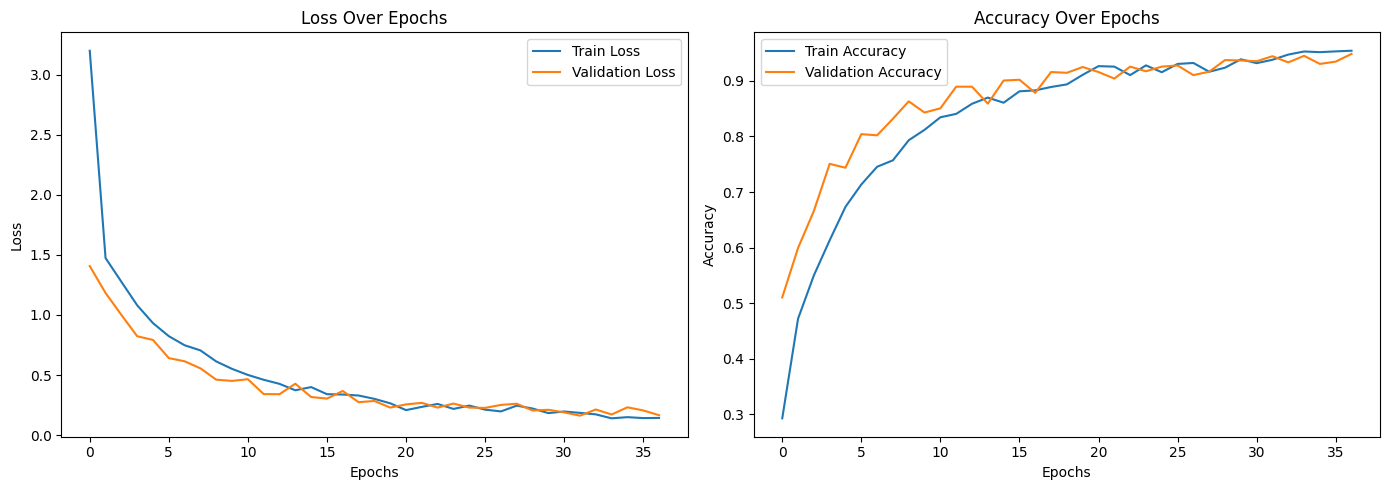

In [12]:
plt.figure(figsize=(14, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Generate predictions on the test set
y_pred = model.predict(X_test_flat)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true_classes = np.argmax(y_test, axis=1)  # True labels

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


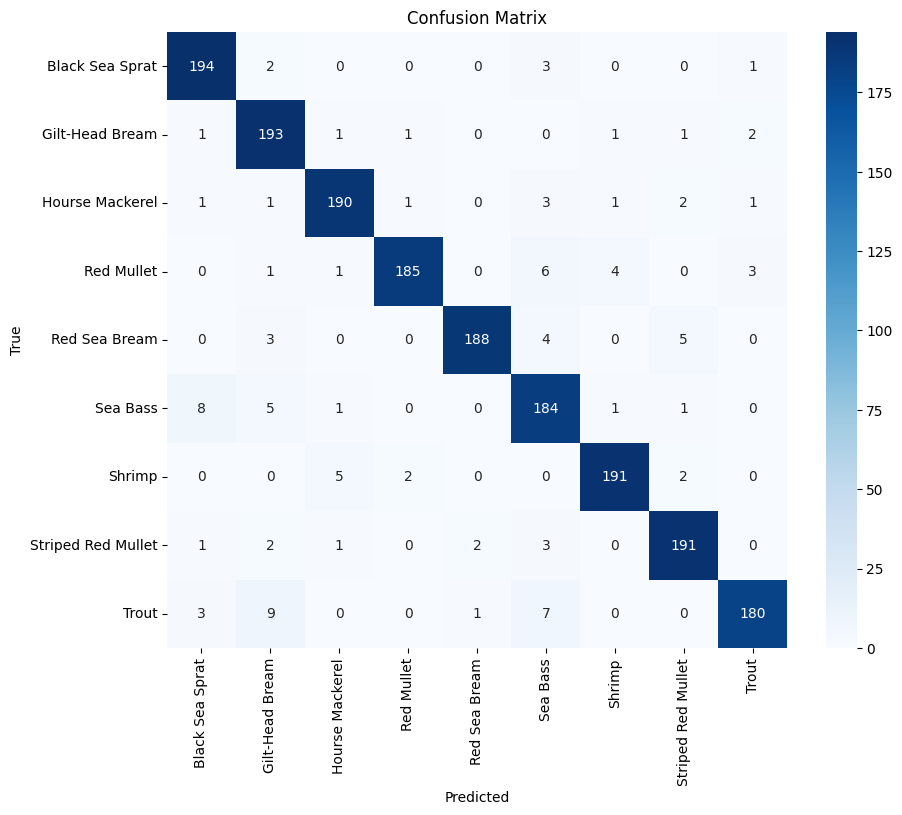

In [14]:
# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(train_df['label']),
            yticklabels=np.unique(train_df['label']))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Classification report
print("Classification Report:\n", classification_report(y_true_classes, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       200
           1       0.89      0.96      0.93       200
           2       0.95      0.95      0.95       200
           3       0.98      0.93      0.95       200
           4       0.98      0.94      0.96       200
           5       0.88      0.92      0.90       200
           6       0.96      0.95      0.96       200
           7       0.95      0.95      0.95       200
           8       0.96      0.90      0.93       200

    accuracy                           0.94      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800



**5. Hyperparameter Optimization**

The accuracy of the ANN model was initially **0.12**. Then, the dropout rate was decreased from 0.5 to 0.3, and a learning rate was introduced. With these changes, the accuracy increased to **0.3**. Next, the dropout rate was further reduced to 0.2, the "patience" value in the Early Stopping function was increased from 2 to 5, and the batch size was increased from 32 to 64. Additionally, one more hidden layer was added. These adjustments boosted the accuracy to **0.7**. A fourth hidden layer was also added, but it did not significantly affect the accuracy. Moreover, changing the number of epochs had no impact on the accuracy. However, when the number of hidden layers was reduced from four to two, the accuracy improved to **0.94**, and the model became balanced.